# First transformations & explorations

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.cross_validation import train_test_split
import csv

In [98]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def RMSPE(y, yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

In [99]:
def transform_data(sales, stores):
    stores['CompetitionDistance'] = stores.CompetitionDistance.fillna(100000)
    sales['Date'] = pd.to_datetime(sales.Date)
    sales = sales.sort_values('Date')
    sales = sales.drop(['Open', 'Date'], axis=1)
    if 'Customers' in sales.columns:
        sales = sales.drop(['Customers'], axis=1)
    sales = pd.get_dummies(sales, columns=['DayOfWeek', 'StateHoliday'])
    stores = stores.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
    stores = pd.get_dummies(stores, columns=['StoreType', 'Assortment'])
    all_data = pd.merge(sales, stores, on='Store')
    all_data = all_data.fillna(0)
    return all_data

In [100]:
train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')
store = pd.read_csv('../../data/store.csv')

In [101]:
all_data = transform_data(train, store)

In [102]:
y = all_data['Sales']
X = all_data.drop(['Store', 'Sales'], axis=1)
y = y.values
X = X.values

In [103]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
forest = rfr(n_estimators=15)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_cv)
error = RMSPE(y_cv,y_pred)
print("RMSPE:", error)
print("R^2:", forest.score(X_cv, y_cv))

('RMSPE:', 0.20783403124917135)
('R^2:', 0.86809009574376395)


## Look at real sales data for a specific store in 2013

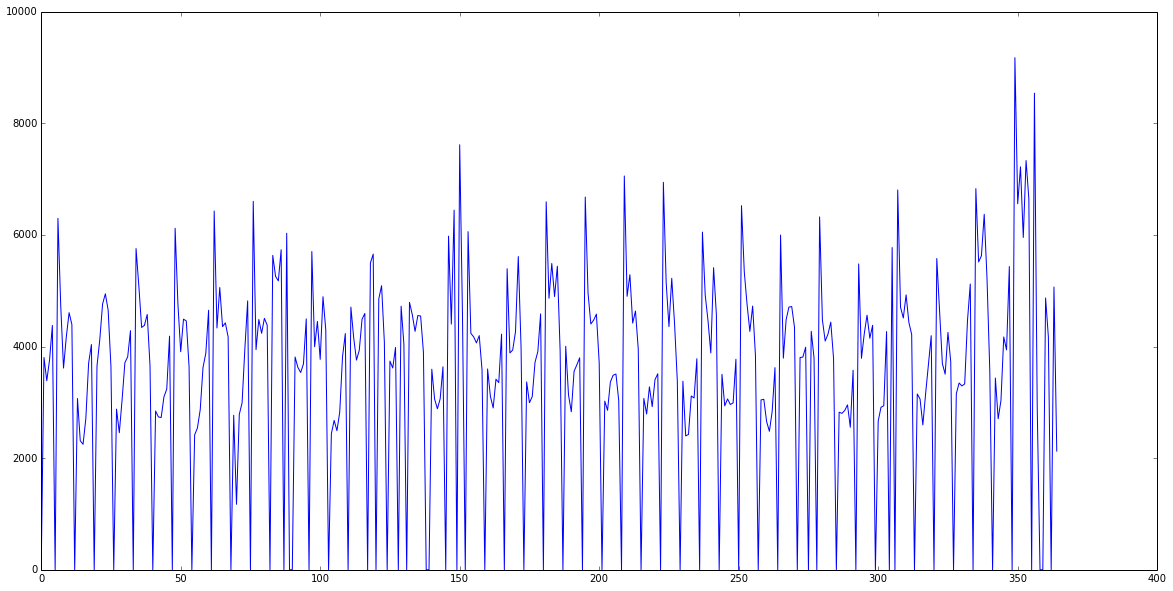

In [105]:
plt.figure(figsize=(20,10))
train_timeseries = train.set_index('Date')
train_timeseries.index = pd.to_datetime(train_timeseries.index)
train_timeseries = train_timeseries.sort_index()
plt.plot(train_timeseries[train_timeseries.Store==50]['2013']['Sales'].values)

## Plot predictions and real sales data for specific store

Using *training data* here. Just to see which patterns the model misses in the time series.

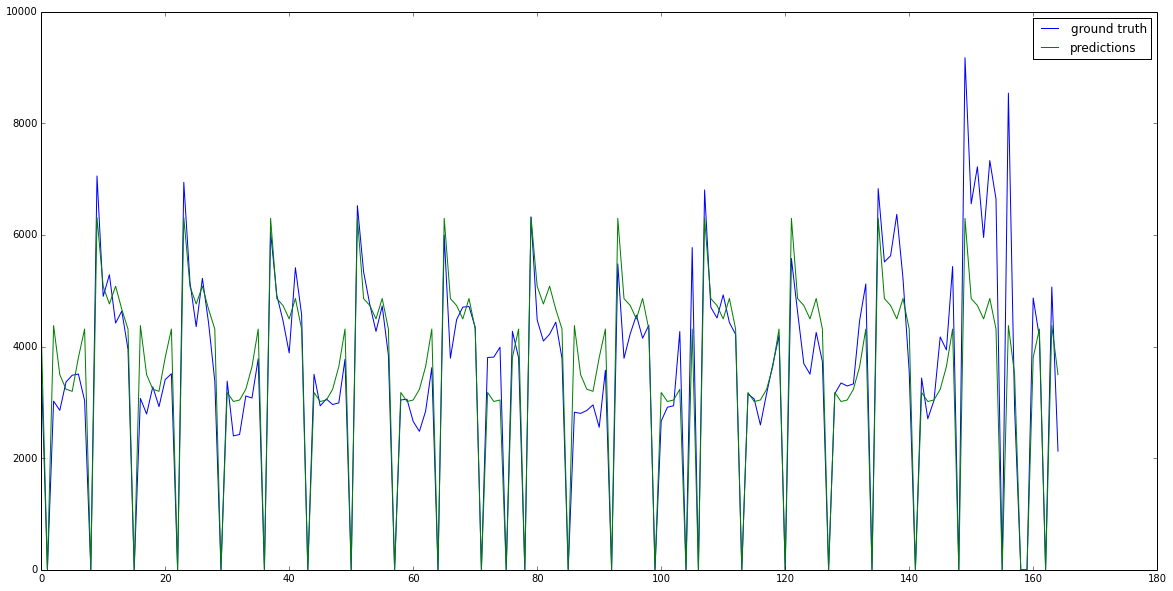

In [106]:
plt.figure(figsize=(20,10))
store1 = all_data[all_data.Store==50]
store1_y = store1['Sales'].values
store1_X = store1.drop(['Store', 'Sales'], axis=1).values
store1_y_pred = forest.predict(store1_X)
line_truth = plt.plot(store1_y[200:365], label='ground truth')
line_pred = plt.plot(store1_y_pred[200:365], label='predictions')
plt.legend()

## Train forest with full training set

In [107]:
forest = rfr(n_estimators=20)
forest.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Transform competition test data to match our training data

In [108]:
transformed_test = transform_data(test, store)
ids = transformed_test.Id
transformed_test = transformed_test.reindex_axis(all_data.columns, axis='columns', fill_value=0)
X_test = transformed_test.drop(['Store', 'Sales'], axis=1).values

Output predicted sales to CSV

In [109]:
y_pred = forest.predict(X_test)
s1 = pd.Series(ids, name='Id')
s2 = pd.Series(y_pred, name='Sales')
results = pd.concat([s1, s2], axis=1)
results = results.sort_values('Id')
results.to_csv(path_or_buf='submissions/current.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

## Todos

* Try to model:
 * spikes before christmas and sometime during the year (easter?, summer?, before school holidays?)
 * competition that opened since 2013
 * promo2
 * Store closed yesterday? tomorrow?
 * Missing competition distance data
* Find out if random forests need normalized data, intercept
* Why do I get dummy StateHoliday_0 twice? Might not be a problem
* Use customer data for something?